Initializing the neural network...
Loading image...
Pre-processing image...
Original image shape:(496, 500, 3) and remember it should be in H, W, C!
Model's input shape is 224x224
Orginal aspect ratio: 1.00806451613
New image shape:(224, 225, 3) in HWC
After crop:  (224, 224, 3)
NCHW:  (1, 3, 224, 224)
results shape:  (1, 1, 2)
results:  [[[ 0.00204705  0.99795294]]]
Verdict:  Male


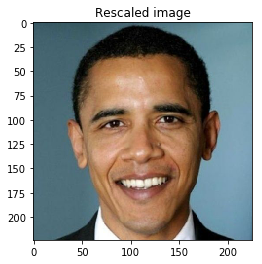

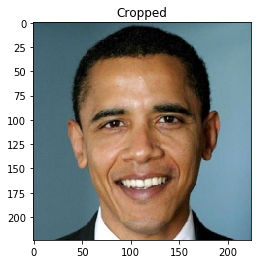

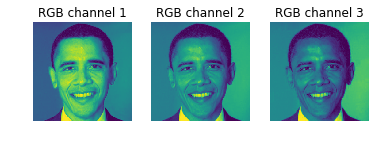

In [5]:
%matplotlib inline

from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace
import urllib2

def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img, input_height, input_width):
    print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
    print("Model's input shape is %dx%d") % (input_height, input_width)
    aspect = img.shape[1]/float(img.shape[0])
    print("Orginal aspect ratio: " + str(aspect))
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    pyplot.figure()
    pyplot.imshow(imgScaled)
    pyplot.axis('on')
    pyplot.title('Rescaled image')
    print("New image shape:" + str(imgScaled.shape) + " in HWC")
    return imgScaled

# IMAGE_LOCATION = "https://i.pinimg.com/736x/87/82/fc/8782fc8220561fe4a7dddb07aa15525a--face-reference-female-faces.jpg"
#camera girl: IMAGE_LOCATION = "http://www.geofflawrence.com/images/holding-the-camera/holding-the-camera-wrongly.jpg"
#obama: 
IMAGE_LOCATION = "http://files.abovetopsecret.com/images/member/a456eee0e838.jpg"
#IMAGE_LOCATION =  "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"

INPUT_IMAGE_SIZE = 224
MEAN = 128

# initialize the neural net
print "Initializing the neural network..."

os.chdir('/Users/evgenybaskakov/Dropbox (Personal)/caffe2_gender')
with open("init_net.pb") as f:
    init_net = f.read()
with open("predict_net.pb") as f:
    predict_net = f.read()        

p = workspace.Predictor(init_net, predict_net)

# load image
print "Loading image..."
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)

# transform image
print "Pre-processing image..."
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print "After crop: " , img.shape

# visualize the image
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Cropped')

# switch to CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - MEAN

# add batch size
img = img[np.newaxis, :, :, :].astype(np.float32)
print "NCHW: ", img.shape

# run the net and return prediction
results = p.run([img])

# turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)
print "results shape: ", results.shape
print "results: ", results

results = results[0][0]

print "Verdict: ", 'Female' if results[0] > results[1] else 'Male'
